<a href="https://colab.research.google.com/github/SolinSM/GAN/blob/main/CGAN_Model_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CGAN**

## **libraries**
Run this line for first run

!pip install tensorflow==2.15.0 scikit-learn==1.2.2 keras==2.15.0   #python 3.10.12

In [2]:
#!pip install tensorflow==2.15.0 scikit-learn==1.2.2 keras==2.15.0   #python 3.10.12

#for read csv file
import os
import pandas as pd
import numpy as np
import random


# pre-process
##for stop word
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

## not used now
#import unicodedata     # Remove accents
#import string

import sklearn

## for tokenization
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer      ## WordPunctTokenizer --> splits words based on punctuation boundaries.

## for divide data to (train / test/ validate)
from sklearn.model_selection import train_test_split


# for one-hor encode (sentence to 2D)
from sklearn.preprocessing import OneHotEncoder

# for TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

# for plot
import matplotlib.pyplot as plt


from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder


# for TDCGAN , CGAN
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input,
    Concatenate,
    Embedding,
    Dense,
    LeakyReLU,
    BatchNormalization,
    Dropout,
    Reshape,
)

import keras
from keras.optimizers import Adam


import time
# taqadum in arabic , progress/process in english
from tqdm.notebook import tqdm
#from tqdm import tqdm


# Suppress warnings from numpy
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)


import keras.backend as K
import numpy as np


# for Evaluate
from sklearn.metrics import classification_report


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
print(tf. __version__)          # tensorflow version   2.15.0
!python --version               # python version    3.10.12
print(sklearn.__version__)      # scikit-learn version    1.2.2
print(keras.__version__)        # keras version    2.15.0

2.15.0
Python 3.10.12
1.2.2
2.15.0


## **definition**

In [4]:

NUM_DISCRIMINATORS = 1
GENERATOR_DROPOUT_RATE = 0.2  #0.1
DISCRIMINATOR_DROPOUT_RATE = 0.3      #Adjust the dropout rate to prevent overfitting during training.
LEAKY_RELU_ALPA = 0.2

NUM_EPOCHS = 500      #1000
BATCH_SIZE = 128      #30
OPTIMIZER_LR = 0.0001                 # learning rate
OPTIMIZER_BETAS = (0.5, 0.999)

# Save losses for plotting
d0_real_losses = []   # left discriminator losses   (disc 0)
d0_fake_losses = []   # left discriminator losses   (disc 0)
d0_losses      = []   # discriminator losses        (disc 0)
"""
d1_real_losses = []   # Middle discriminator losses (disc 1)
d1_fake_losses = []   # Middle discriminator losses (disc 1)
d1_losses      = []   # discriminator losses        (disc 1)

d2_real_losses = []   # right discriminator losses  (disc 2)
d2_fake_losses = []   # right discriminator losses  (disc 2)
d2_losses      = []   # discriminator losses        (disc 2)
"""
g_losses       = []   # generator losses
d_losses       = []   # discriminator losses



## **Color list + TextStyle**

In [5]:
colors_list = [
    'Red', 'Green', 'Blue', 'Purple', 'Orange', 'Pink', 'Brown', 'Yellow',
    'Cyan', 'Magenta', 'Lime', 'Teal', 'Lavender', 'Maroon', 'Navy', 'Olive', 'Silver', 'Gold',
    'Indigo', 'Turquoise', 'Beige', 'Crimson', 'Salmon','Tan','Lime', 'Fuchsia', 'Plum',
    'Tomato', 'Violet']

class TextStyle:
    # Font Styles
    BOLD = '\033[1m'
    DIM = '\033[2m'
    UNDERLINE = '\033[4m'
    BLINK = '\033[5m'
    REVERSE = '\033[7m'
    RESET_ALL = '\033[0m'

    # Font Colors
    BLACK = '\033[30m'
    RED = '\033[31m'
    GREEN = '\033[32m'
    YELLOW = '\033[33m'
    BLUE = '\033[34m'
    MAGENTA = '\033[35m'
    CYAN = '\033[36m'
    WHITE = '\033[37m'

    # Background Colors
    BG_BLACK = '\033[40m'
    BG_RED = '\033[41m'
    BG_GREEN = '\033[42m'
    BG_YELLOW = '\033[43m'
    BG_BLUE = '\033[44m'
    BG_MAGENTA = '\033[45m'
    BG_CYAN = '\033[46m'
    BG_WHITE = '\033[47m'


## **Read Multi Files csv**

In [23]:
""" ----------------- Read CSV File Function ----------------- """
def read_csv_files(dataset_directory, percent):
  print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Handling Read CSV Files ------------{TextStyle.RESET_ALL}")

  files = [f for f in os.listdir(dataset_directory) if f.endswith('.csv')]

  if files == []:
    print('Not found any csv files')
  else:
    print('Your files are: ', files)

    np_array_values = []
    data_df = pd.DataFrame()
    firstFile = True

    for file in files:
      file_path = os.path.join(dataset_directory, file)   # csv_file_path
      print('File Path: ', file_path)

      try:
        df = ''
        df = pd.read_csv(file_path, encoding = "ISO-8859-1")  #.head()   #,low_memory=False   ISO-8859-1
        total_rows = len(df)
        print('Total rows in df/file: ', total_rows)

        num_rows = int(total_rows * (percent / 100))
        print('Total rows in df/file 100%: ', num_rows)


        """ Start From Teacher Code """
        # Generate a list of random indices
        random_indices = random.sample(range(total_rows), num_rows)
        #print('random_indices: ' , random_indices)

        # Select the random rows from the DataFrame
        temp_df = df.iloc[random_indices]
        if(firstFile):
          # Concatenate all DataFrames into one
          data_df = temp_df.copy()
          firstFile = False
        else:
          # Concatenate all DataFrames into one
          data_df = pd.concat([data_df,temp_df], ignore_index=True)

        print(data_df)
        return data_df
        """ End From Teacher Code """

        ## Add DataFrame to new CSV file
        #new_csv_file_path = os.path.join(dataset_directory, 'new_sqli.csv')  # "/content/dataset/new_sqli.csv"
        #df.to_csv(new_csv_file_path, index=False)

      except Exception as e:
        print('Can not Read File called : ', file)
        print('File path: ', file_path)
        print("Errpr Exception e : ", e)


#""" ----------------- Apply Code ----------------- """
#dataset_directory = "/content/datasets"   #files_path
#percent = 100
#data = read_csv_files(dataset_directory,percent)


## **Pre-process Functions**

### **Tokenization + filter_stop_words**

In [7]:
## ----- filter_stop_words ------ ##
"""
Filters stop words from a list of tokens, keeping words in the exception list.
Args:
    word_tokens: A list of tokens (words).
    except_stop_word: A set of stop words to be excluded from removal (optional).
Returns:
    A list of tokens with stop words removed, except for those in the exception list.
"""
def filter_stop_words(word_tokens):
    stop_words = set(stopwords.words('english'))  # Load default stop words
    except_stop_word = set(['and', 'or', 'where', 'from', 'over'])  # Exception list defined here

    filtered_sentence = []
    for w in word_tokens:
        if w in except_stop_word or w not in stop_words:
            filtered_sentence.append(w)

    return filtered_sentence





## ----- Tokenization ------ ##
"""
# Tokenization + stop word
Handle Main column in dataset 'sentence'
by encoding it using (Tokenization handlling OOV + stop_word  , TfidfVectorizer )
OOV :
    ensures any new words in the test data are mapped to a common OOV token.
    ensure robustness and accuracy when dealing with new, unseen words.
"""
def tokenization_text(sentences, x_name = ''):      #sentences):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Tokenization + stop word (" , x_name , f") ------------{TextStyle.RESET_ALL}")

    #sentences = X['sentence']
    print('sentences: ' , len(sentences) )

    #define OOV token text to use it when new token appear and not in train tokens data
    #oov_token='<OOV>'

    tokenizer = WordPunctTokenizer()
    #tokenizer.oov_token = '<UNK>'   # '<OOV>'
    tokens = []

    for sentence in sentences:
        #word_tokens = word_tokenize(sentence)
        word_tokens = tokenizer.tokenize(sentence)

        # Replace OOV words with the specified token
        #word_tokens_with_oov = [token if token in tokenizer.vocab else oov_token for token in word_tokens]

        # stop_words  (filter tokeniz word by remove any stop word with except some word as from, where ... etc)
        filtered_tokens = filter_stop_words(word_tokens)


        ########tokens.extend(filtered_tokens)    ## for test 8:18 20-5-2024    #######
        tokens.append(filtered_tokens)

        # Join tokens back to string for TF-IDF
        #tokens.append(' '.join(filtered_tokens))


    #print('len tokens before unique: ', len(tokens))
    #print('1 tokens: ', tokens )

    # Get unique tokens ( Remove duplicates using set() and convert back to list )
    ######tokens = list(set(tokens))    #######
    #print('len tokens after unique: ', len(tokens))
    #print('2 tokens: ', tokens )

    print("tokens len:", len(tokens) )
    """
    i = 0
    for token in tokens:
      if i < 5:
        print("tokens:", tokens[i])
        i = i + 1
      else:
        break
    """
    return tokens



### **one_hot_encoder**

In [8]:
## ----- one_hot_encoder_func ------ ##

def one_hot_encoder_func(X, one_hot_cols):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Perform one-hot encoding ------------{TextStyle.RESET_ALL}")
    one_hot_encoded_df = X.copy()

    # Perform one-hot encoding
    one_hot_encoded_1 = pd.get_dummies(one_hot_encoded_df, columns=one_hot_cols, prefix=one_hot_cols)
    #print('one_hot_encoded : ', one_hot_encoded_1)

    # Get only columns that is original columns and needed as them + not neet to convert them from boolean to int
    origin_needed_cols = one_hot_encoded_1[[col for col in one_hot_encoded_1.columns if
                                            not any(col.startswith(col_name) for col_name in one_hot_cols)]]

    # Get only columns that created new by one-hoe-encoder (get_dummies)
    one_hot_cols_df = one_hot_encoded_1[[col for col in one_hot_encoded_1.columns if
                                          any(col.startswith(col_name) for col_name in one_hot_cols)]]

    # Convert one_hot_cols_df values from boolean to integers (1 and 0)
    one_hot_cols_df = one_hot_cols_df.astype(int)

    # Concatenate the one_hot_cols_df with the origin_needed_cols
    X = pd.concat([origin_needed_cols, one_hot_cols_df], axis=1)
    print('end one hot encoder : \n', X.head())

    """
      Ex of previous row:
          i  color  size              i     color_blue   color_red   size_M   size_S
          ---------------           ---------------------------------------------------
          0   red    S                0         0            1          0       1
          1   blue   M          ==>   1         1            0          1       0
          2   blue   S                2         1            0          0       1
    """

    return X


### **target_encode**

In [9]:
## ----- target_encode ------ ##

"""
  # target encoding/mean encoding
  # useful for encoding categorical features into numerical features based on their relationship with the target variable.
  # target_column : deciding it will depend on the objective of your analysis or model training.
  # It is typically the variable you're trying to predict in a supervised learning task.

  NOTE::
    Target-encode might not be ideal for SQL sentences
      1. SQL sentences are unstructured text data with potentially high cardinality and no inherent ordering.
      2. Target encoding works better for categorical variables with a clear relationship to the target,
          rather than free-form text.
"""
def target_encode(X, y, target_encode_cols, target_column):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Perform target encoding ------------{TextStyle.RESET_ALL}")

    target_encoded_df = X.copy()
    print('target_encoded_df: ', target_encoded_df.head())

    # this colum choisen because it is needed to predict sentence is normal or sqli
    #target_column = class_Col # y   #encoding_col
    for col in target_encode_cols:

        # Check if the column exists
        if col not in X.columns:
            raise KeyError(f"Column '{col}' not found in DataFrame")

        # Concate y  --> class_Col to X now then next remove it
        #class_Col_df = y.copy()
        X = pd.concat([X, y], axis=1)

        # Calculate the mean target value for each category  (the mean float no for each category in column)
        mean_encoding = X.groupby(col)[target_column].mean()
        print('mean_encoding: ', mean_encoding.head())

        # Map the mean values back to the DataFrame
        target_encoded_df[col + '_encoded'] = X[col].map(mean_encoding)
        #print('target_encoded_df: ', target_encoded_df.head())

        # Drop class_Col added to do this part
        X = X.drop(target_column, axis=1)

        # Drop the original categorical column
        target_encoded_df = target_encoded_df.drop(col, axis=1)
        print('target_encoded_df: ', target_encoded_df.head())

        X = target_encoded_df

    return X



## **CGAN Pre-process**

In [10]:

def load_and_preprocess_data1(df_data):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Pre-Proccess Data ------------{TextStyle.RESET_ALL}")

    # ----------- Check for NaN Values ------------- #
    print("Checking for NaN vallues ...")
    if df_data.isnull().values.any():
        print("NaN values found in the dataset. Handling missing values...")
        # Handling missing values by imputing with mean (you can choose other methods as well)
        df_data = df_data.fillna(df_data.mean())
    df_data.replace([np.inf, -np.inf,np.nan,np.NAN],0, inplace=True)

    if df_data.isnull().sum().sum() == 0 : # and np.isinf(df_data.values).sum() == 0 :
        print('Done Handling missing values')


    # ----------- lowercase + strip 'sentence' ------------- #
    # Convert to lowercase & Remove spaces in start and end
    df_data['sentence'] = df_data['sentence'].str.lower().str.strip()


    # ------------------------------------  separate target from predictors ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- separate target from predictors -------{TextStyle.RESET_ALL}")

    # Step 1 : define targent column name and no. class in it
    class_Col = 'attack_type'
    n_classes = df_data[class_Col].nunique()      # no. classes/category in class_Col (attack_type)     n_classes = pd_frames['attack_type'].nunique()

    # Step 2: define datatype for columns
    df_data['len_payload'] = df_data['len_payload'].astype(int)


    if df_data[class_Col].dtype == 'object' :
        y_datatype = 'object'
        # Step 3: Convert Target Column 'attack_type'
        # 3.1 : Convert the 'attack_type' column to One-hot encode
        #encoder = OneHotEncoder(sparse=False)
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        encoded_attack_type = encoder.fit_transform(df_data[[class_Col]])
        encoded_attack_type_df = pd.DataFrame(encoded_attack_type, columns=encoder.get_feature_names_out([class_Col]))

        # 3.2 : Concatenate the encoded attack_type with the original DataFrame
        df_data = pd.concat([df_data.drop(class_Col, axis=1), encoded_attack_type_df], axis=1)
        df_data1_copy = df_data.copy()

        # Step 4: Identify the feature columns (X) and the target columns (y)
        # Assuming the target columns are all the one-hot encoded columns (with 'attack_type_' prefix)
        # Automatically find the target columns based on the columns added during encoding
        target_columns = [col for col in df_data.columns if col.startswith('attack_type_')]

        # Features are all the other columns
        feature_columns = [col for col in df_data.columns if col not in target_columns]

        df_data1 = df_data[feature_columns]
        y = df_data[target_columns]
        X = df_data1

    else:
        y_datatype = 'int'
        df_data[class_Col] = df_data[class_Col].astype(int)     #pd_frames['attack_type'] = pd_frames['attack_type'].astype(int)
        y = df_data[class_Col]      # main col to classify at end (class_Col --> attack_type)

        # remove y column (class_Col) from data columns list
        df_data1 = df_data.copy()
        df_data1.drop(columns=[class_Col], inplace=True)         #X.drop([class_Col], axis=1, inplace=True)
        #X_columns = df_data1.columns       #['sentence', 'len_payload', ....]
        X = df_data1


    print('X : ' , X)
    print('y: ', y)
    #print('y cols: ', y.columns)
    #y_columns = [col for col in y.columns]
    #print('y_columns: ', y_columns)

    """
    ###### Not used in out datasets ######
    # ------------------------------------ Apply encoding for categorical columns if any ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- Handling Categorical Features -------{TextStyle.RESET_ALL}")

    # all categorical columns (any column with object dataType ant its value not number)
    categorical_cols = [cname for cname in X.columns if
                        X[cname].dtype == "object"]
    print("Categorical columns len: ", len(categorical_cols))
    print("Categorical columns: ", categorical_cols)

    # Columns that will be one-hot encoded
    # X[cname].nunique() < 4   : less that 4 categories in the column
    one_hot_cols = [cname for cname in X.columns if
                      X[cname].nunique() < 4 and
                      X[cname].dtype == "object"]
    print('one_hot_cols : ', one_hot_cols)
    print("No. Columns need to encoded using one-hot-encoding: ", len(one_hot_cols))

    # Skip this columns because it needs to use TfidFVectorizer With it
    skip_cols = [main_text_col]

    # Columns that will be target encoded  (will get columns with more than 4 categories in it :: like 'sentence' column)
    target_encode_cols = list(set(categorical_cols)-set(one_hot_cols) - set(skip_cols) )
    print('target_encode_cols : ', target_encode_cols)
    print("No. Columns need to encoded using target-encoding: ", len(target_encode_cols))


    # Encode categorical columns if there is any
    if(len(categorical_cols) > 0):

      # to perform one-hot encoding on specified columns of a DataFrame.
      if(len(one_hot_cols)> 0):
        X = one_hot_encoder_func(X, one_hot_cols)

      if(len(target_encode_cols) > 0):
        target_column = class_Col
        X = target_encode(X, y, target_encode_cols, target_column)

    else:
      print("No categorical columns, nothing todo")
    """



    # ------------------------------------ train_test_split ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- Divide the dataset into training (70%) and testing (30%) -------{TextStyle.RESET_ALL}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    print("Training data:\n")
    print("X_train : \n", X_train , '\n')
    print("y_train : \n", y_train)

    if y_datatype == 'int':
        y_train = pd.DataFrame(y_train, columns=[class_Col])        #'attack_type'
        y_test  = pd.DataFrame(y_test,  columns=[class_Col])

    print(f"Training rows (70% of Dataset)", "X_train shape: " , X_train.shape , " -- y_train shape: ", y_train.shape)
    print(f"Testing rows (30% of Dataset)", "X_test shape: " , X_test.shape , " -- y_test shape: ", y_test.shape)

    print('X_train head: ', X_train.head)
    print('y_train head: ', y_train.head)

    X_train = X_train.reset_index(drop=True)
    X_test  = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test  = y_test.reset_index(drop=True)

    origin_x_train = X_train
    origin_x_test = X_test



    # ------------------------------------ Tokenization ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- Tokenization -------{TextStyle.RESET_ALL}")

    X_train_tokenized = tokenization_text(X_train['sentence'], 'x_train')
    X_test_tokenized = tokenization_text(X_test['sentence'], 'x_test')

    # Join tokens back into strings for each sentence
    X_train_joined_sentences = [' '.join(tokens) for tokens in X_train_tokenized]     #X_train_copy['sentence_joined'] = ' '.join(X_train_tokenized)
    X_test_joined_sentences = [' '.join(tokens) for tokens in X_test_tokenized]
    #/print('joined_sentences: ' , joined_sentences)



    # ------------------------------------ TfidfVectorizer ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- TfidfVectorizer -------{TextStyle.RESET_ALL}")
    tfidf_vectorizer = TfidfVectorizer(max_features=100)  # Set max_features to 50 for simplicity (Limit to top 100 features)  #dtype='float32'

    ## --- X_train
    # without Tokenization step ( X_train['sentence'] )  # With Tokenization Step  ( X_train_joined_sentences )
    X_tfidf_values = tfidf_vectorizer.fit_transform(X_train_joined_sentences)
    X_tfidf_selected_features = tfidf_vectorizer.get_feature_names_out()
    df_x_train = X_train.copy()
    df_x_train.drop(columns=['sentence'], inplace=True)
    df_tfidf_x_train = pd.DataFrame(X_tfidf_values.toarray(), columns=X_tfidf_selected_features)
    x_train_data = pd.concat([df_x_train, df_tfidf_x_train], axis=1)      # Concatenate TF-IDF features with the original data excluding the sentence column

    ## --- X_test
    # without Tokenization step ( X_test['sentence'] )  # With Tokenization Step  ( X_test_joined_sentences )
    X_test_tfidf_values = tfidf_vectorizer.transform(X_test_joined_sentences)
    X_test_tfidf_selected_features = tfidf_vectorizer.get_feature_names_out()
    df_x_test = X_test.copy()
    df_x_test.drop(columns=['sentence'], inplace=True)
    df_tfidf_x_test = pd.DataFrame(X_test_tfidf_values.toarray(), columns=X_test_tfidf_selected_features)
    x_test_data = pd.concat([df_x_test, df_tfidf_x_test], axis=1)       # Concatenate TF-IDF features with the original data excluding the sentence column
    print('end tfidf')



    # ------------------------------------ MinMaxScaler ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- Scaling Features using 'MinMaxScaler' -------{TextStyle.RESET_ALL}")
    scaler = MinMaxScaler()

    X_train_scaled = scaler.fit_transform(x_train_data)     #, axis=1)
    X_test_scaled = scaler.transform(x_test_data)           #, axis=1)

    # Convert the scaled numerical features back to DataFrames
    x_train_data = pd.DataFrame(X_train_scaled, columns=x_train_data.columns)     #X_train_scaled_df
    x_test_data = pd.DataFrame(X_test_scaled, columns=x_test_data.columns)        #X_test_scaled_df



    # ------------------------------------ PCA for feature selection ------------------------------------ #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------- PCA for feature selection -------{TextStyle.RESET_ALL}")
    #pca = PCA(n_components=50)  # Reduce to 50 components
    pca = PCA(n_components=0.85, random_state=453)    #0.95

    ## ------>> X_train << ------ ##
    print('pca x_train data')
    X_train_pca = pca.fit_transform(x_train_data)     # Fit & Transform PCA on the training data

    # Convert PCA results back to DataFrames and concatenate with the original non-sentence columns
    # Generate new feature names for PCA components
    train_pca_feature_names = [f'pca_{i+1}' for i in range(X_train_pca.shape[1])]
    X_train_pca_df = pd.DataFrame(data=X_train_pca, columns=train_pca_feature_names)      # Create a DataFrame with the PCA-transformed data
    x_train_data = X_train_pca_df
    print('end x_train_data')


    ## ------>> X_test << ------ ##
    print('pca x_test data')
    X_test_pca = pca.transform(x_test_data)
    test_pca_feature_names = [f'pca_{i+1}' for i in range(X_test_pca.shape[1])]
    X_test_pca_df = pd.DataFrame(data=X_test_pca, columns=test_pca_feature_names)
    x_test_data = X_test_pca_df
    print('end x_test_data')



    # variance ratio : show how much information (variance) can be attributed to each of the principal components.
    # Calculate explained variance ratio and cumulative variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance      = np.cumsum(explained_variance_ratio)    # Calculates the cumulative explained variance ratio for each component.
    #print('explained_variance_ratio: ', explained_variance_ratio)
    #print('cumulative_variance: ', cumulative_variance)


    # Plot component variance and cumulative variance
    plt.figure(figsize=(12, 4))
    colors_list = ['Red','Orange', 'Blue', 'Purple','Green','Pink','Gray','Tan','Lime','Cyan']

    # Plot component variance with percentages
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio * 100, label='Component Variance')
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, marker='o', color='r', label='Cumulative Variance')

    plt.title('Variance Explained by Principal Components\n Dataset ')
    plt.xlabel('Principal Component')
    plt.ylabel('Percentage of Variance Explained (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

    print('x_train_data head', x_train_data.head)
    print('X_train_pca_df shape: ', x_train_data.shape)
    print('x_test_data shape: ', x_test_data.shape)


    return n_classes, x_train_data, x_test_data, y_train, y_test, origin_x_train, origin_x_test , y_datatype



## **Implement TDCGAN Models**

### **build_generator**

In [11]:

def build_generator(input_dim, num_classes):   # vocabulary_size / num_class
  print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ build_generator ------------{TextStyle.RESET_ALL}")

  GENERATOR_DROPOUT_RATE = 0.2

  # Input layers for data (real or generated) and label
  noise = Input(shape=(input_dim,), name='noise')     # latent space noise (Features , ex: 100 samples, 10 features)
  label = Input(shape=(num_classes,), name='label')   # no need for One-hot encoded label, its numeric
  concatenated = Concatenate()([noise, label])        # Concatenate(axis=-1) is defualt
  print('len noise: ', noise.shape[1])

  # Embedded layer to map noise to lower-dimensional space, It creates a vector representation for the generated point.
  hidden = Embedding(input_dim, num_classes // 2)(concatenated)  # Adjust embedding dim as needed

  # Hidden layers with ReLU activation and dropout
  hidden = Dense(256, activation='relu')(concatenated)  #(hidden)
  hidden = Dropout(GENERATOR_DROPOUT_RATE)(hidden)

  hidden = Dense(128, activation='relu')(hidden)
  hidden = Dropout(GENERATOR_DROPOUT_RATE)(hidden)

  hidden = Dense(64, activation='relu')(hidden)
  hidden = Dropout(GENERATOR_DROPOUT_RATE)(hidden)

  hidden = Dense(32, activation='relu')(hidden)
  hidden = Dropout(GENERATOR_DROPOUT_RATE)(hidden)

  # Output layer with Softmax activation
  generated_text = Dense(input_dim, activation='softmax', name='generated_text')(hidden)
  print('generated_text shape: ', generated_text.shape)

  # Create the generator model
  generator_model = Model(inputs=[noise, label], outputs=generated_text, name='generator')

  generator_model.compile(
      loss='categorical_crossentropy', #'binary_crossentropy',
      optimizer=Adam(learning_rate= 0.0002 , beta_1= 0.5),
      metrics=['accuracy']
  )

  return generator_model

### **build_discriminator**

In [12]:

def build_discriminator(input_dim, num_classes, name, num_hidden_layers, neurons_per_layer, dropout_rate):
  print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ build_discriminator (", name , f") ------------{TextStyle.RESET_ALL}")

  # Input layers for data (real or generated) and label
  # our data is Conditional Generation so label is needed
  data  = Input(shape=(input_dim,), name='data')       # Features    (ex: 100 samples, 10 features)
  label = Input(shape=(num_classes,), name='label')   # Tf-IDF Vectorizer not One-hot encoded label
  concatenated = Concatenate()([data, label])   #Concatenate(axis=-1) is defualt
  print('len data: ', data.shape[1])

  # Hidden layers with LeakyReLU activation and dropout
  # These layers extract the features
  hidden = data
  for i in range(num_hidden_layers):
    if i == 0:
      #hidden = Dense(neurons_per_layer[i], activation='leaky_relu', alpha=0.2)(concatenated)
      hidden = Dense(neurons_per_layer[i])(concatenated)
      hidden = LeakyReLU(alpha=0.2)(hidden)
      hidden = Dropout(dropout_rate)(hidden)
    else:
      #hidden = Dense(neurons_per_layer[i], activation='leaky_relu', alpha=0.2)(hidden)   ##negative_slope  === alpha
      hidden = Dense(neurons_per_layer[i])(hidden)
      hidden = LeakyReLU(alpha=0.2)(hidden)
      hidden = Dropout(dropout_rate)(hidden)
      # Consider adding for training stability (important) but this will make disc summary non-trainable params != 0
      #hidden = BatchNormalization()(hidden)

  ## Flatten ?!

  # Output layer for real vs fake prediction (Real/fake classification)
  validity_output = Dense(1, activation='sigmoid', name='validity_output')(hidden)

  # Output layer for class label prediction (normal/sqli attack classification)   (Auxiliary classification / class_output)
  auxiliary_output = Dense(num_classes, activation='softmax', name='auxiliary_output')(hidden)

  print('ttsm - real/fake validity_output : ', validity_output)
  print('ttsm - normal/sqli auxiliary_output : ', auxiliary_output)

  # Build and compile the discriminator model
  discriminator_model = Model(inputs=[data, label], outputs=[auxiliary_output, validity_output], name=name)    # inputs=data

  # auxiliary_output (attack_type maybe) may binary_crossentropy  (0 --> normal / 1 --> SQLi)
  #'auxiliary_output': 'categorical_crossentropy', // binary_crossentropy
  discriminator_model.compile(
      loss={'auxiliary_output': 'categorical_crossentropy', 'validity_output': 'binary_crossentropy'},
      optimizer=Adam(learning_rate= 0.0002 , beta_1= 0.5),
      metrics={'auxiliary_output': 'accuracy', 'validity_output': 'accuracy'})

  return discriminator_model


### **create_combined_model**

In [13]:

def build_combined_model(input_dim, num_classes, generator_model, discriminators_model):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ build_combined_model ------------{TextStyle.RESET_ALL}")

    print('comb 0')
    # functional API model has its input shape, it is suited for more complex models, accepting branches, concatenations, etc.
    #noise = Input(shape=(input_dim,))
    noise_data  = Input(shape=(input_dim,), name='noise_data')
    labels = Input(shape=(num_classes,), name='labels')
    print('labels sm : ', labels)

    # Generator output features for the discriminator
    generated_data = generator_model([noise_data, labels])      # generated_features

    print('comb 1')
    # Define list for Discriminator outputs for the generated data
    discriminators_class_outputs =[]
    discriminators_validity_outputs =[]

    """ With loop (num of Disc. (3 Disc)  ) """
    # For the combined model, we only train the generator (disable discriminator training) for all 3 Discr.
    for discriminator in discriminators_model:
        # Freeze discriminator (Freeze Trainable Parameters) -> this make lots params non-trainable
        # For the combined model, we only train the generator (disable discriminator training) for all 3 Discr.
        discriminator.trainable = False

    """
        ## Why Lists and not Concatenate Directly?
        ## Concatenating directly within the loop might lead to issues if the discriminators have
        ## slightly different output shapes (e.g., due to variations in architecture).
    """
    # another way (not in loop) see -->  ##### Comment 1 #####
    for discriminator in discriminators_model:
        # Discriminator Output for (class label prediction) and (validity --> real vs fake prediction)
        class_outputs , validity_outputs = discriminator([generated_data, labels])
        ##$$$$$$$class_outputs , validity_outputs = discriminator.predict([generated_data, labels])
        discriminators_class_outputs.append(class_outputs)
        discriminators_validity_outputs.append(validity_outputs)



    discriminators_outputs = {
                                'class': discriminators_class_outputs,
                                'validity': discriminators_validity_outputs
                            }


    # discriminators_outputs[class][0]  => discriminator 0 , [1] disc 1 , [2] disc 2
    print('comb 2')
    print('shap disc class output discriminators_outputs[class]: ', discriminators_outputs['class'] )
    print('shap disc validity output discriminators_outputs[validity]: ', discriminators_outputs['validity'] )
    print('shap disc class output discriminators_outputs[class][0]: ', discriminators_outputs['class'][0] )
    print('shap disc class output: ', discriminators_outputs['class'][0].shape[-1] )

    print('discriminators_outputs : ', discriminators_outputs)



    print('comb 3')
    # Concatenate discriminators outputs
    concatenated_discriminator_class_outputs = Concatenate()(discriminators_class_outputs)
    concatenated_discriminator_validity_outputs = Concatenate()(discriminators_validity_outputs)


    print('comb 4')
    # Output for class label prediction
    class_output = Dense(num_classes, activation='softmax', name='comb_class_output')(concatenated_discriminator_class_outputs)   #e_class_output)

    # Output for real vs fake prediction
    validity_output = Dense(1, activation='sigmoid', name='comb_validity_output')(concatenated_discriminator_validity_outputs)    #e_validity_output)


    print('comb 5')
    # Build the combined model
    combined_model = Model(inputs=[noise_data, labels],outputs=[class_output,validity_output], name='Combined_Model_TDCGAN')
    print('comb 6')

    combined_model.compile(
        loss={'comb_class_output': 'categorical_crossentropy', 'comb_validity_output': 'binary_crossentropy'},  # categorical_crossentropy
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5),
        metrics={'comb_class_output': 'accuracy', 'comb_validity_output': 'accuracy'}  #['accuracy']  #
    )
    print(77)

    return combined_model


### **print_models_summary**

In [14]:
def print_models_summary(generator_model, combined_model, discriminators_model):
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Print Summary ------------{TextStyle.RESET_ALL}")


    print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nGenerator summary (CGAN): \n{TextStyle.RESET_ALL}")
    generator_model.summary(show_trainable=True,expand_nested=True)

    i = 1
    for discriminator in discriminators_model:
        print(f"{TextStyle.BOLD}\nDiscriminator " , i , f" summary (CGAN): \n{TextStyle.RESET_ALL} ")
        discriminator.summary(show_trainable=True,expand_nested=True)
        i = i + 1


    print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nCombined_model summary (TDCGAN):\n{TextStyle.RESET_ALL} ")
    combined_model.summary(show_trainable=True)



## **Train CGAN**

In [15]:
import time

# input_dim = latent_dim = noise_dim

def train_cgan(batch_size, noise_dim, num_classes, generator_model, discriminators_model, combined_model,
          X_train, y_train, NUM_EPOCHS):

  #X_train = np.array(X_train)  #.values.tolist()   #.toarray()  #to_numpy()   #csr_matrix.toarray
  #y_train = np.array(y_train)   #.values.tolist()   #.toarray()  #to_numpy()
  X_train = X_train.to_numpy()
  y_train = y_train.to_numpy()

  # Save losses for plotting
  d0_real_losses = []   # left discriminator losses   (disc 0)
  d0_fake_losses = []   # left discriminator losses   (disc 0)
  d0_losses      = []   # discriminator losses        (disc 0)
  g_losses       = []   # generator losses
  d_losses       = []   # discriminator losses


  # -----------> Epochs <---------- #
  for epoch in tqdm(range(NUM_EPOCHS), desc="Epoch", unit="epoch"):
      d_loss_list = []
      g_loss_list = []
      start = time.time()

      #print(1)
      # Get a batch of real data
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      real_data   = X_train[idx]
      real_labels = y_train[idx]

      #print(2)
      # Ensure real_labels has the correct shape
      one_hot_encoder = OneHotEncoder(sparse_output=False)
      one_hot_labels = one_hot_encoder.fit_transform(np.array(y_train).reshape(-1, 1))
      real_labels = one_hot_labels[idx]
      #print('len one-hot real_labels: ', len(real_labels))        #128
      #print('len one-hot real_labels 10: ', real_labels[:10])       # [ [1. 0.] [1. 0.] [0. 1.] .... ]

      #print(3)
      # Sample a random batch of noise
      noise = np.random.normal(0, 1,size=(batch_size, noise_dim))
      real_labels1 = real_labels #np.random.normal(0, 2,size=(batch_size, num_classes))
      #print('noise', noise[:10])
      #print('real_labels1', real_labels1[:10])

      #print('3 a')
      #print('noise shape: ', noise.shape)
      #print('real_labels1 shape: ', real_labels1.shape)
      # Generate fake data using the generator -- Generate a batch of fake data
      ##$generated_data = generator_model([noise, real_labels])    # more direct and convenient during training
      generated_data = generator_model.predict([noise, real_labels1], verbose='0')
      #print('3 b')




      # ---------------------
      #  Train Discriminator
      # ---------------------
      #print('4')
      valid = np.ones((batch_size, 1))  #tf.ones((batch_size, 1), dtype=tf.float32)
      fake  = np.zeros((batch_size, 1))  #tf.zeros((batch_size, 1), dtype=tf.float32)

      # -------->   Disc 0   <--------- #
      #print('4 disc 0')
      disc_loss_real_0 = discriminators_model[0].train_on_batch( [real_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': valid })[0]
      disc_loss_fake_0 = discriminators_model[0].train_on_batch( [generated_data, real_labels1], {'auxiliary_output': real_labels1, 'validity_output': fake })[0]
      d_loss_0 = 0.5 * np.add(disc_loss_real_0, disc_loss_fake_0)   #take average loss from real and fake images.


      d0_real_losses.append(disc_loss_real_0)
      d0_fake_losses.append(disc_loss_fake_0)
      d0_losses.append(d_loss_0)



      # ---------------------
      #  Train Generator
      # ---------------------
      #noise = np.random.normal(0, 1,size=(batch_size, noise_dim))
      g_loss = combined_model.train_on_batch([noise, real_labels1], [real_labels1, valid])
      g_losses.append(g_loss[0])



      # Print the loss every few epochs (Print progre)
      # can remove it & print epoch all time OR  at finish (epoch % 100)
      if epoch % 100 == 0 or epoch == NUM_EPOCHS:
          # try this --->  direct g_loss_list not np.mean(g_loss_list)
          #print (
          tqdm.write(f'{TextStyle.BOLD}{TextStyle.BLUE}Epoch: {epoch}, \n  \
                    Mean Generator Loss: {np.mean(g_losses)}, \n \
                    Mean Discriminator Loss: {np.mean(d0_losses)}\n  \
                    Generator Loss: {g_loss[0]:.3f}, \n  \
                    Discriminators Loss: [D1 loss: {d_loss_0:.3f}  \
                    {TextStyle.RESET_ALL}' ,end=''
                )
          print (f'Took {time.time()-start} seconds. \n\n')

  print('----- End Epoch : -----', )




  ## ------- Plot TDCGAN Training Losses Curves ------- ##
  print('--- plot_losses ---')
  # Define labels for each loss
  labels      = ['Generator Loss' , 'Disc Loss' ]
  colors_list = ['Red'            , 'Blue'      ]
  epochs = list(range(NUM_EPOCHS))

  plt.figure(num= 'normal_1', figsize=(12, 6))
  plt.subplot(2, 1, 1)

  plt.plot(epochs, g_losses, color=colors_list[0], label=labels[0])
  plt.plot(epochs, d0_losses, color=colors_list[1], label=labels[1])

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('CGAN Training Loss Curves')
  plt.legend()
  #plt.grid(True)
  #plt.tight_layout()
  plt.show()

  # Optional: Save the plot as an image (empty content)
  #plt.savefig('tdcgan_losses.png')



  ## ------- Plot TDCGAN Training (3 Discriminator) Real-fake Loss Curves ------- ##
  print('--- plot_3discs ---')
  labels      = ['Disc 0 Real' , 'Disc 0 Fake']
  colors_list = ['Red'         ,   'Blue'     ]
  #colors_list = ['Red','Orange', 'Blue', 'Purple','Green','Pink','Gray','Tan','Lime','Cyan']
  epochs = list(range(NUM_EPOCHS))

  #plt.figure()
  plt.figure(num= 'normal_21', figsize=(12, 6))
  #plt.subplot(2, 1, 2)

  plt.plot(epochs, d0_real_losses, color=colors_list[0], label=labels[0])
  plt.plot(epochs, d0_fake_losses, color=colors_list[1], label=labels[1])

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('CGAN Training (Discriminator) Real-fake Loss Curves')
  plt.legend()
  plt.show()


  return one_hot_encoder




## **Balance using cgan**

### **Int target_column**

In [17]:
def int_target_col_fun(y_data, input_dim, features_cols, class_Col, generator_model, one_hot_encoder, goal_rows_per_class, y_datatype):
    print('y_data : ' , y_data[:10])

    noise_dim = input_dim
    categories = y_data[class_Col]       # without head column  used in balanced TDCGAN

    # Count ( # rows (instance)) the occurrences of each value in class_Col,  len(labels_dic) is equal to n_classes
    labels_dic = y_data.value_counts()     #class_counts    y_data = pd.Index([0,0,1,0,1], name ='attack_type')
    print('labels_dic: ', labels_dic)
    """
      ex res:
          class_counts :  attack_type
          1    3
          0    2
          Name: count, dtype: int64
    """

    # Generate synthetic features and labels
    synthetic_features = []
    synthetic_labels = []


    # Check if all values are equal
    is_samples_equal = True if labels_dic.nunique() == 1 else False

    # Updata goal_rows_per_class if it is less that the max no of label in labels_dic & keep them balanced
    max_class_sample = max(num_samples for label, num_samples in labels_dic.items())    #(major class)
    goal_rows_per_class = max_class_sample   #max(goal_rows_per_class, max_class_sample)
    #goal_rows_per_class = goal_rows_per_class + 2     # to add atleast 2 for the max num_sample
    print('max_class_sample: ' , max_class_sample , '\ngoal_rows_per_class: ', goal_rows_per_class)

    for label, num_samples in labels_dic.items():
        """ ex: label -- num_samples
                  1   --    3
                  0   --    5
        """
        #labels_dic[label]= majority_count - value    # labels_dic[label] same value

        # To balanced using
        if is_samples_equal == False:
            num_samples_to_generate = max_class_sample - num_samples
        else:
            num_samples_to_generate = max_class_sample/2

        #num_samples_to_generate = goal_rows_per_class + ( max_class_sample - num_samples )
        print('num_samples_to_generate : ', num_samples_to_generate)

        if num_samples_to_generate > 0:
            # Generate labels by repeating each unique label based on the specified number of samples
            print("We generate " + str(num_samples_to_generate) + " synthetic samples for attack_type label " + str(label))
            generated_labels = np.repeat(label, num_samples_to_generate).reshape(-1,1)        # [ [1] [1] [1] ... [1] [1] ]
            #generated_labels = np.array(generated_labels).flatten()                           # Output: [1 1 1 1]
            #generated_labels = generated_labels.ravel()

            encoded_labels = one_hot_encoder.transform(generated_labels)      ##$$ try in ecah one / try after concat all
            #print('generated_labels.shape : ', generated_labels.shape , ',  encoded_labels.shape : ', encoded_labels.shape)      # (1002, 1) ,  (1002, 2)
            #print('generated_labels : ', generated_labels)                  # [ [1] [1] [1] ... [1] [1] ]
            #print('encoded_labels : ', encoded_labels)                      # [[0. 1.] [0. 1.] ... [0. 1.] ]


            #one_hot_labels = one_hot_encoder.fit_transform(np.array(y_train).reshape(-1, 1))

            # Generate random sample of noise for each class  (will use num_sample instead of batch_size that used in Train)
            noise = np.random.normal(0, 1,size=(num_samples_to_generate, noise_dim))
            print('noise: ' , noise.shape)
            print('generated_labels: ' , encoded_labels[:5])

            # Generate fake data using the generator -- Generate a batch of fake data
            ##$$generated_data = generator_model([noise, real_labels1])    # more direct and convenient during training
            generated_data = generator_model.predict([noise, encoded_labels], verbose='0')      #encoded_labels
            print('generated_data.shape: ', generated_data.shape)
            #print('generated_data: ', generated_data)

            synthetic_features.append(generated_data)
            synthetic_labels.append(generated_labels)
            #print('len synthetic_features: ' , synthetic_features.shap)
            #print('len synthetic_labels: ' , synthetic_labels.shap)

    print('labels_dic 2 len : ', len(labels_dic))           # 2


    ##$$encoded_labels = one_hot_encoder.transform(synthetic_labels)      ##$$ try in ecah one / try after concat all

    print('10')
    # Concatenate the generated features and labels
    synthetic_features = np.concatenate(synthetic_features)
    synthetic_labels = np.concatenate(synthetic_labels).reshape(-1, 1)

    print('12')
    # Create a DataFrame with synthetic features and labels
    x_synthetic_data = pd.DataFrame(synthetic_features, columns=features_cols)
    y_synthetic_data = pd.DataFrame(synthetic_labels, columns=[class_Col])

    print('x_synthetic_data shape : ' , x_synthetic_data.shape)
    print('y_synthetic_data shape : ' , y_synthetic_data.shape)
    print('x_synthetic_data head : ' , x_synthetic_data.head)
    print('y_synthetic_data head : ' , y_synthetic_data.head)

    synthetic_data = pd.DataFrame(synthetic_features, columns=features_cols)
    synthetic_data[class_Col] = synthetic_labels


    return x_synthetic_data, y_synthetic_data, synthetic_data

### **obj_target_col_fun**

In [18]:
def obj_target_col_fun(y_data, input_dim, features_cols, class_Col, generator_model, one_hot_encoder, goal_rows_per_class, y_datatype):

    noise_dim = input_dim

    # Find y columns names
    #print('y cols: ', y_data.columns)
    y_columns = [col for col in y_data.columns]
    print('y_columns: ', y_columns)

    # Count the occurrences of each category (Count (# rows (instance)) the occurrences of each value in class_Col,  len(labels_dic) is equal to n_classes)
    # category_counts =  y_data.sum(axis=0)  #print('category_counts: ', category_counts)
    categories_counts = y_data.apply(lambda df_y: df_y.value_counts().get(1, 0))
    print("Count of value 1 in each column: ", categories_counts)

    # Check if all values are equal
    is_samples_equal = categories_counts.nunique() == 1
    print('is_samples_equal : ', is_samples_equal)

    labels_dic = y_data.value_counts()
    print('labels_dic: ', labels_dic)
    """
      ex res:
          class_counts :  attack_type_SQLi  attack_type_normal
          1.0               0.0                3
          0.0               1.0                2
          Name: count, dtype: int64
    """

    # Get the maximum value from the counts + Updata goal_rows_per_class if it is less that the max no of label in labels_dic & keep them balanced
    max_class_sample = categories_counts.max()
    goal_rows_per_class = max_class_sample
    print('max_class_sample: ' , max_class_sample , '\ngoal_rows_per_class: ', goal_rows_per_class)


    # Generate synthetic features and labels
    synthetic_features = []
    synthetic_labels = []

    for column in y_data.columns:
        additional_samples_needed = int(max_class_sample - categories_counts[column])     #goal_rows_per_class
        print('column: ', column , ' - additional_samples_needed: ' , additional_samples_needed)

        if additional_samples_needed > 0:

            # Step 1 : Generate new y samples count --> additional_samples_needed
            # Create a new instance with 0.0 for all columns and 1.0 for specific column
            new_instance = {col: 0.0 for col in y_data.columns}
            new_instance[column] = 1.0

            # Convert the new instance to a DataFrame
            new_instance_df = pd.DataFrame([new_instance])

            # Repeat the new instance DataFrame
            repeated_new_instances = pd.concat([new_instance_df] * additional_samples_needed, ignore_index=True)
            print('len repeated_new_instances : ', len(repeated_new_instances) )

            # Convert repeated_new_instances to numpy array
            repeated_new_instances_np = repeated_new_instances.to_numpy()

            #print('encoded_labels : ', encoded_labels)                      # [[0. 1.] [0. 1.] ... [0. 1.] ]
            print('repeated_new_instances_np : ', repeated_new_instances_np)                      # [[0. 1.] [0. 1.] ... [0. 1.] ]
            print('repeated_new_instances : ', repeated_new_instances)                      # [[0. 1.] [0. 1.] ... [0. 1.] ]

            synthetic_labels.append(repeated_new_instances_np)
            #print('len synthetic_labels: ' , synthetic_labels.shap)


            print('step 2')
            # Step 2 : Generate random sample of noise for each class  (will use num_sample instead of batch_size that used in Train)
            noise = np.random.normal(0, 1,size=(additional_samples_needed, noise_dim))
            #print('noise: ' , noise.shape)
            print('step 2 - end noise')

            print('noise: ' , noise.shape)
            print('repeated_new_instances: ' , repeated_new_instances.shape)

            # Generate fake data using the generator -- Generate a batch of fake data
            generated_data = generator_model.predict([noise, repeated_new_instances_np], verbose='0')
            print('generated_data.shape: ', generated_data.shape)  # , ' /n generated_data: ', generated_data)

            synthetic_features.append(generated_data)
            #print('len synthetic_features: ' , synthetic_features.shap)


    print('9')
    synthetic_labels = repeated_new_instances

    print('10')
    # Concatenate the generated features and labels
    synthetic_features = np.concatenate(synthetic_features)
    #synthetic_labels = np.concatenate(synthetic_labels).reshape(-1, 1)


    print('12')
    # Create a DataFrame with synthetic features and labels
    x_synthetic_data = pd.DataFrame(synthetic_features, columns=features_cols)
    y_synthetic_data = pd.DataFrame(synthetic_labels, columns=y_columns)

    print('x_synthetic_data shape : ' , x_synthetic_data.shape)
    print('y_synthetic_data shape : ' , y_synthetic_data.shape)
    print('x_synthetic_data head : ' , x_synthetic_data.head)
    print('y_synthetic_data head : ' , y_synthetic_data.head)

    synthetic_data = pd.concat([x_synthetic_data, y_synthetic_data], ignore_index=True)

    #synthetic_data = pd.DataFrame(synthetic_features, columns=features_cols)
    #synthetic_data[class_Col] = synthetic_labels


    return x_synthetic_data, y_synthetic_data, synthetic_data

    # Append the repeated new instances to the original DataFrame
    #y_data = pd.concat([y_data, repeated_new_instances], ignore_index=True)


### **test**

In [19]:
y_data = {
   'attack_type_SQLi': [0.0, 0.0, 1.0, 1.0, 1.0, 0.0],
   'attack_type_normal': [1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
   'attack_type_xss': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
}
df = pd.DataFrame(y_data)

# Count the number of occurrences of the value `1` in each column
categories_counts = df.apply(lambda x: x.value_counts().get(1, 0))
print("Count of value 1 in each column:")
print(categories_counts)

labels_dic = df.value_counts()
print('labels_dic: ', labels_dic)

# Check if all counts are equal
all_equal = categories_counts.nunique() == 1
print("All counts are equal:", all_equal)

# Get the maximum value from the counts
max_value = categories_counts.max()
print("Maximum value:", max_value)

labels_dic = categories_counts


for column in df.columns:
    additional_samples_needed = int(max_value - categories_counts[column])
    if additional_samples_needed > 0:
        # Create a new instance with 0.0 for all columns and 1.0 for specific column
        new_instance = {col: 0.0 for col in df.columns}
        new_instance[column] = 1.0

        # Convert the new instance to a DataFrame
        new_instance_df = pd.DataFrame([new_instance])

        # Repeat the new instance DataFrame
        repeated_new_instances = pd.concat([new_instance_df] * additional_samples_needed, ignore_index=True)
        print('len repeated_new_instances : ', len(repeated_new_instances) )

        # Append the repeated new instances to the original DataFrame
        df = pd.concat([df, repeated_new_instances], ignore_index=True)


# Shuffle the DataFrame to randomize the order
df = df.sample(frac=1).reset_index(drop=True)

print("Balanced DataFrame:")
print(df)



Count of value 1 in each column:
attack_type_SQLi      3
attack_type_normal    2
attack_type_xss       1
dtype: int64
labels_dic:  attack_type_SQLi  attack_type_normal  attack_type_xss
1.0               0.0                 0.0                3
0.0               1.0                 0.0                2
                  0.0                 1.0                1
Name: count, dtype: int64
All counts are equal: False
Maximum value: 3
len repeated_new_instances :  1
len repeated_new_instances :  2
Balanced DataFrame:
   attack_type_SQLi  attack_type_normal  attack_type_xss
0               1.0                 0.0              0.0
1               0.0                 1.0              0.0
2               1.0                 0.0              0.0
3               0.0                 0.0              1.0
4               0.0                 1.0              0.0
5               0.0                 1.0              0.0
6               1.0                 0.0              0.0
7               0.0        

### **Main Function**

In [20]:
#goal_rows_per_class = 1000
def balance_data_using_cgan(y_data, input_dim, features_cols, class_Col, generator_model, one_hot_encoder, goal_rows_per_class, y_datatype):

    if y_datatype == 'object':
        print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ balance_data_using_cgan (Obj) ------------{TextStyle.RESET_ALL}")
        x_synthetic_data, y_synthetic_data, synthetic_data = obj_target_col_fun(y_data, input_dim, features_cols, class_Col, generator_model, one_hot_encoder, goal_rows_per_class, y_datatype)

    else:
        print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ balance_data_using_cgan (int) ------------{TextStyle.RESET_ALL}")
        x_synthetic_data, y_synthetic_data, synthetic_data = int_target_col_fun(y_data, input_dim, features_cols, class_Col, generator_model, one_hot_encoder, goal_rows_per_class, y_datatype)


    return x_synthetic_data, y_synthetic_data, synthetic_data




## **Evaluate CGAN**

In [21]:

def evaluate_cgan(X_test, y_test, n_classes, batch_size, one_hot_encoder, y_datatype): ###$$$, encoder): #track 1
    # ---------------------------> X_test dataset in CGAN <--------------------------- #
    print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ evaluate_cgan ------------{TextStyle.RESET_ALL}")
    #input_dim = X_test.shape[1]

    # get column is_real
    y_test_real = y_test['is_real']                        # .astype(int)
    y_test.drop(columns=['is_real'], inplace=True)         # remove is_real column from y_test columns list
    #print('y_test_real : ' , y_test_real)
    #print('y_test : ' , y_test)

    if y_datatype == 'object':
        y_test_n = y_test

    else:
        ##print('e2')
        # One-hot encode labels for evaluation
        one_hot_labels = one_hot_encoder.transform(np.array(y_test).reshape(-1, 1))
        y_test_n = one_hot_labels

    print('e3')

    # Evaluate the combined model on real data
    y_pred_combined_real = combined_model.predict([X_test, y_test_n])
    """
    y_pred_combined_real = [
        array(            ---> SQLi/normal   (predicted_labels_real)
              [
                  [0.6907744, 0.3092256],
                  [0.5507812, 0.4492188],
                  [0.4492188, 0.5507812],
              ], dtype=float32
        ),
        array(            --->  Real/Fake    (predicted_real_vs_fake_combined)
              [
                  [0.47635472],
                  [0.47627473],
                  [0.4762748 ],
              ], dtype=float32
        )
    ]
    """

    print('y_pred_combined_real[0] : ', y_pred_combined_real[0])
    print('predicted_labels_real : ', y_pred_combined_real[1])



    # ----------- For Class Prediction (SQLi / normal)  ------------- #
    print('e5')
    print('y_test_n : ' , y_test_n)

    # Convert y_true to 1-dimensional array where each item is the first value in [SQLi, normal] (Take the first column 'SQLi' of y_true)

    predicted_labels_real = y_pred_combined_real[0][:, 0]   #.astype(int)
    print('predicted_labels_real : ', predicted_labels_real)                # predicted_labels_real :  [0.6907744 0.5507812 0.4492188 ... ]  --> >= 0.5 SQli , <0.5 normal
    predicted_labels_real = np.round(predicted_labels_real)
    print('predicted_labels_real 1 : ', predicted_labels_real)

    y_test_n = np.array(y_test_n)     #    y_test_n = y_test_n.to_numpy()
    y_true = y_test_n[:, 0]                                   #.astype(int)   y_true_labels
    print('y_true : ' , y_true)

    #y_true_labels = np.argmax(y_test_n, axis=1)       # Convert y_true from one-hot encoded format to single column of class labels (take second column 'normal')
    #predicted_labels_real = np.argmax(y_pred_combined_real[0], axis=1)

    """
    y_true = y_test_n --->
    attack_type_SQLi  attack_type_normal
          1.0                 0.0
          0.0                 1.0
          0.0                 1.0


    original_values = encoder.inverse_transform(y_pred_combined_real[0])
    """

    #y_true = encoder.inverse_transform(y_test_n)
    #predicted_labels_real = encoder.inverse_transform(y_pred_combined_real[0])

    #y_true = y_true.flatten()   # 1-dimension
    #predicted_labels_real = predicted_labels_real.flatten()   # 1-dimension
    #print('encoder.inverse_transform y_true : ' , y_true)
    #print('encoder.inverse_transform predicted_labels_real : ' , predicted_labels_real)


    # ----------- For Real vs. Fake Prediction (Real / Fake)  ------------- #
    print('e6')
    ##num_samples = len(X_test)
    ##y_test_real = np.ones(num_samples)


    print('e7')
    # Reshape predicted_real_vs_fake to match the shape of y_test_real (flatten() function converts it to a 1-dimensional array)
    predicted_real_vs_fake_combined = y_pred_combined_real[1]
    predicted_real_vs_fake = predicted_real_vs_fake_combined.flatten()   # 1-dimension
    predicted_real_vs_fake = np.round(predicted_real_vs_fake)

    # Real / Fake
    print('y_test_real : ' , y_test_real)                                       # y_test_real             : [1. 1. 1. ... 1. 1. 1.]
    print('predicted_real_vs_fake : ' , predicted_real_vs_fake)                 # predicted_real_vs_fake  : [[0.] [0.] [0.] ... [0.] [0.] [0.]]




    # ----------- Way 1 ------------- #
    ## way 1
    print(f"{TextStyle.BOLD}{TextStyle.RED}------ Way 1 ------{TextStyle.RESET_ALL}")

    # Print the classification report for the combined model on real data
    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Class Prediction):{TextStyle.RESET_ALL}")
    ###$$$print(classification_report(encoder.inverse_transform(y_test_n), encoder.inverse_transform(predicted_labels_real),zero_division=1))  # track 1
    print(classification_report(y_true, predicted_labels_real, zero_division=1))

    ##print('e7')
    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Real vs. Fake Prediction):{TextStyle.RESET_ALL}")
    print(classification_report(y_test_real, predicted_real_vs_fake,zero_division=1))


    # ----------- Way 2 ------------- #

    ## way 2
    from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score, recall_score, confusion_matrix

    print(f"{TextStyle.BOLD}{TextStyle.RED}------ Way 2 ------{TextStyle.RESET_ALL}")
    print('-------')
    print(f"{TextStyle.BOLD}\nAnother way for performance (Combined Model - Real Data - Class Prediction):{TextStyle.RESET_ALL}")
    accuracy = accuracy_score(y_true, predicted_labels_real)
    print("Accuracy: ", accuracy)
    mae = mean_absolute_error(y_true, predicted_labels_real)
    print("Mean Absolute Error:", mae)
    # Calculate Precision score
    precision = precision_score(y_true, predicted_labels_real, average='macro')
    print("Precision:", precision)
    recall = recall_score(y_true, predicted_labels_real, average='macro')
    print("Recall:", recall)
    f1 = 2 * ( (precision * recall) / (precision + recall) )
    print("F1:", f1)
    conf_matrix = confusion_matrix(y_true, predicted_labels_real)
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]
    print("True Positives (TP):", TP)
    print("True Negatives (TN):", TN)
    print("False Positives (FP):", FP)
    print("False Negatives (FN):", FN)

    """
    print('-------')
    print(f"{TextStyle.BOLD}\nAnother way for performance (Combined Model - Real Data - Real vs. Fake Prediction):{TextStyle.RESET_ALL}")
    y_testing = np.ones(num_samples)
    y_predection = np.round(predicted_real_vs_fake_combined)

    accuracy = accuracy_score(y_testing, y_predection)
    print("Accuracy: ", accuracy)
    mae = mean_absolute_error(y_testing, y_predection)
    print("Mean Absolute Error:", mae)
    # Calculate Precision score
    precision = precision_score(y_testing, y_predection, average='macro')
    print("Precision:", precision)
    recall = recall_score(y_testing, y_predection, average='macro')
    print("Recall:", recall)
    """




    # ----------- Way 3 ------------- #
    """
    ## way 3
    Update discriminator metrics based on true labels and predicted labels.
    Parameters:
      - y_true: True labels (ground truth).   -->  y_test_n
      - y_pred: Predicted labels.             -->
    Returns:
      - metrics_dict: Dictionary containing updated discriminator metrics.
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    print(f"{TextStyle.BOLD}{TextStyle.RED}------ Way 3 ------{TextStyle.RESET_ALL}")

    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Class Prediction):{TextStyle.RESET_ALL}")
    metrics_dict = {}
    metrics_dict['accuracy']  = accuracy_score(y_true, predicted_labels_real)          # Calculate accuracy
    metrics_dict['precision'] = precision_score(y_true, predicted_labels_real)         # Calculate precision
    metrics_dict['recall']    = recall_score(y_true, predicted_labels_real)            # Calculate recall
    metrics_dict['f1']        = f1_score(y_true, predicted_labels_real)                # Calculate F1 score

    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Accuracy  : {TextStyle.RESET_ALL}"   , metrics_dict['accuracy']    )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Precision : {TextStyle.RESET_ALL}"   , metrics_dict['precision']   )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Recall    : {TextStyle.RESET_ALL}"   , metrics_dict['recall']      )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}F1 score  : {TextStyle.RESET_ALL}"   , metrics_dict['f1']          )


    print(f"{TextStyle.BOLD}\nClassification Report (Combined Model - Real Data - Real vs. Fake Prediction):{TextStyle.RESET_ALL}")
    metrics_dict1 = {}
    metrics_dict1['accuracy']  = accuracy_score(y_test_real, predicted_real_vs_fake)          # Calculate accuracy
    metrics_dict1['precision'] = precision_score(y_test_real, predicted_real_vs_fake)         # Calculate precision
    metrics_dict1['recall']    = recall_score(y_test_real, predicted_real_vs_fake)            # Calculate recall
    metrics_dict1['f1']        = f1_score(y_test_real, predicted_real_vs_fake)                # Calculate F1 score

    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Accuracy  : {TextStyle.RESET_ALL}"   , metrics_dict1['accuracy']   )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Precision : {TextStyle.RESET_ALL}"   , metrics_dict1['precision']  )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}Recall    : {TextStyle.RESET_ALL}"   , metrics_dict1['recall']     )
    print(f"{TextStyle.BOLD}{TextStyle.GREEN}F1 score  : {TextStyle.RESET_ALL}"   , metrics_dict1['f1']         )




In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Example data
y_pred_combined_real = [
    np.array([
        [0.6907744, 0.3092256],
        [0.5507812, 0.4492188],
        [0.5507812, 0.4492188],
    ], dtype=np.float32),
    np.array([
        [0.47635472],
        [0.47627473],
        [0.4762748],
    ], dtype=np.float32)
]

y_true = np.array([
    [1.0, 0.0],
    [0.0, 1.0],
    [0.0, 1.0]
])

# Step 1: Convert y_true to 1-dimensional array where each item is the first value in [SQLi, normal] (Take the first column 'SQLi' of y_true)
y_true_labels = y_pred_combined_real[0][:, 0]

print('y_true_labels 2 : ' , y_true_labels)


xx = [ 0.47635472, 0.47627473, 0.4462748 ]
predicted_real_vs_fake = np.round(xx) #.astype(int)

#predicted_real_vs_fake = np.round(y_pred_combined_real[1])
print('predicted_real_vs_fake : ' , predicted_real_vs_fake)


#y_true_labels = np.argmax(y_true, axis=1)       # Step 1: Convert y_true from one-hot encoded format to single column of class labels (take second column 'normal')

#encoder = OneHotEncoder(sparse=False)
#encoded_attack_type = encoder.fit_transform(df[['attack_type']])
#original_values = encoder.inverse_transform(y_true)
#print('y_true_labels : ' , y_true_labels)


"""
from sklearn.preprocessing import LabelEncoder

encoder1 = LabelEncoder()
# Fit and transform the target column 'y'
y_encoded = encoder1.fit_transform(y_true)
print('y_encoded : ', y_encoded)
"""

y_true_labels 2 :  [0.6907744 0.5507812 0.5507812]
predicted_real_vs_fake :  [0. 0. 0.]


"\nfrom sklearn.preprocessing import LabelEncoder\n\nencoder1 = LabelEncoder()\n# Fit and transform the target column 'y'\ny_encoded = encoder1.fit_transform(y_true)\nprint('y_encoded : ', y_encoded)\n"

In [ ]:
import numpy as np

# Example data
y_true_labels = [0.6907744, 0.5507812, 0.307812]

# Use np.round() to round values according to the specified criteria
rounded_labels = np.round(y_true_labels)

# Print the rounded labels
print(rounded_labels)

[1. 1. 0.]


## **Run CGAN**

------------ Handling Read CSV Files ------------
Your files are:  ['before_only_4000.csv']
File Path:  /content/datasets/before_only_4000.csv
Total rows in df/file:  4000
Total rows in df/file 100%:  4000
                                               sentence  attack_type  \
2425                                           opopnaco            0   
2803                                                ido            0   
1275  1"  )  )   )  waitfor delay '0:0:5' and   (  (...            1   
3495                                            iocntrl            0   
3804              VARIABLE task_name2 VARCHAR2 ( 255 )             0   
...                                                 ...          ...   
2238                                          sol sieso            0   
3352                                    carrizales oate            0   
1737  -3458' )  where 2053 = 2053 or 4747 = dbms_uti...            1   
3653                                   medina del campo            0   
31

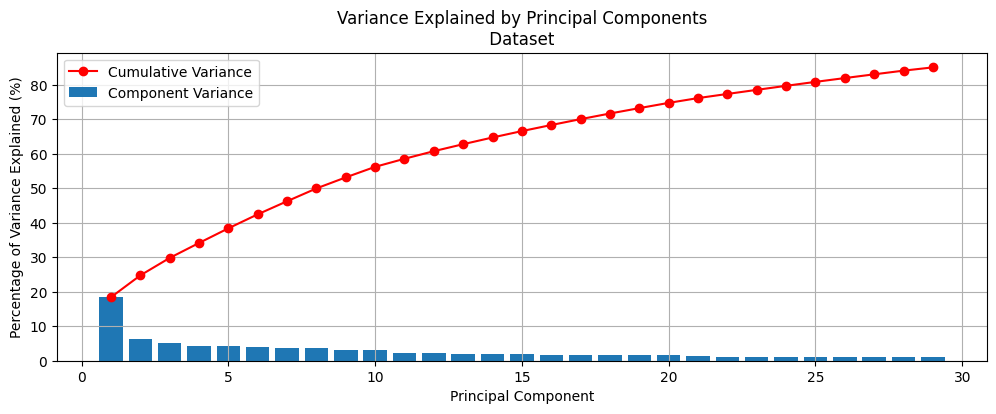

x_train_data head <bound method NDFrame.head of          pca_1     pca_2     pca_3     pca_4     pca_5     pca_6     pca_7  \
0    -0.181277 -0.125614 -0.111538 -0.027729 -0.001444 -0.000919 -0.003351   
1    -0.131808 -0.141348 -0.010450 -0.047187  0.001977 -0.006874  0.006708   
2     0.909744 -0.039089  0.048470  0.054047  0.006357 -0.024911  0.004869   
3    -0.182851 -0.125971 -0.114286 -0.027584 -0.001520 -0.000809 -0.003555   
4    -0.163828  0.263801  0.170007 -0.193353  0.059489  0.047943  0.100199   
...        ...       ...       ...       ...       ...       ...       ...   
2795 -0.181802 -0.125733 -0.112454 -0.027681 -0.001469 -0.000883 -0.003419   
2796 -0.178654 -0.125018 -0.106959 -0.027970 -0.001317 -0.001103 -0.003010   
2797 -0.104148 -0.108090  0.023088 -0.034814  0.002283 -0.006324  0.006652   
2798  0.715272  0.223914 -0.141014 -0.120481  0.010465  0.094352  0.021701   
2799  0.890635 -0.040962  0.012676  0.052386  0.006984 -0.026359  0.002498   

         pca_8 

Epoch:   0%|          | 0/500 [00:00<?, ?epoch/s]

Epoch: 0, 
                      Mean Generator Loss: 1.9091625213623047, 
                     Mean Discriminator Loss: 1.418056607246399
                      Generator Loss: 1.909, 
                      Discriminators Loss: [D1 loss: 1.418                      Took 3.7858645915985107 seconds. 


Epoch: 100, 
                      Mean Generator Loss: 2.048074135685911, 
                     Mean Discriminator Loss: 0.798908070910095
                      Generator Loss: 1.970, 
                      Discriminators Loss: [D1 loss: 0.243                      Took 0.12682747840881348 seconds. 


Epoch: 200, 
                      Mean Generator Loss: 1.9599389282625113, 
                     Mean Discriminator Loss: 0.4421540359776486
                      Generator Loss: 1.841, 
                      Discriminators Loss: [D1 loss: 0.021                      Took 0.11376285552978516 seconds. 


Epoch: 300, 
                      Mean Generator Loss: 1.9085507408725066, 
              

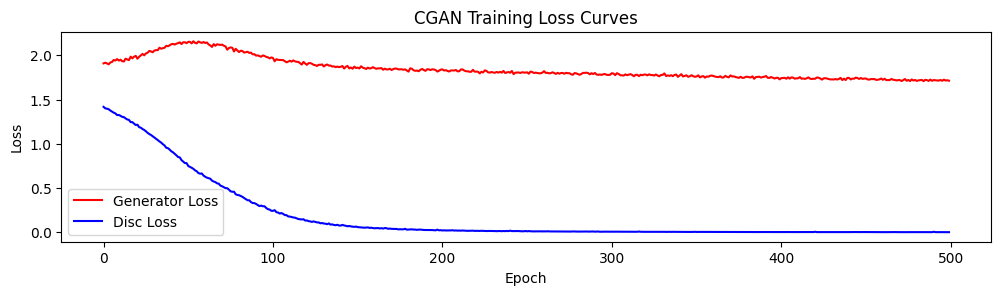

--- plot_3discs ---


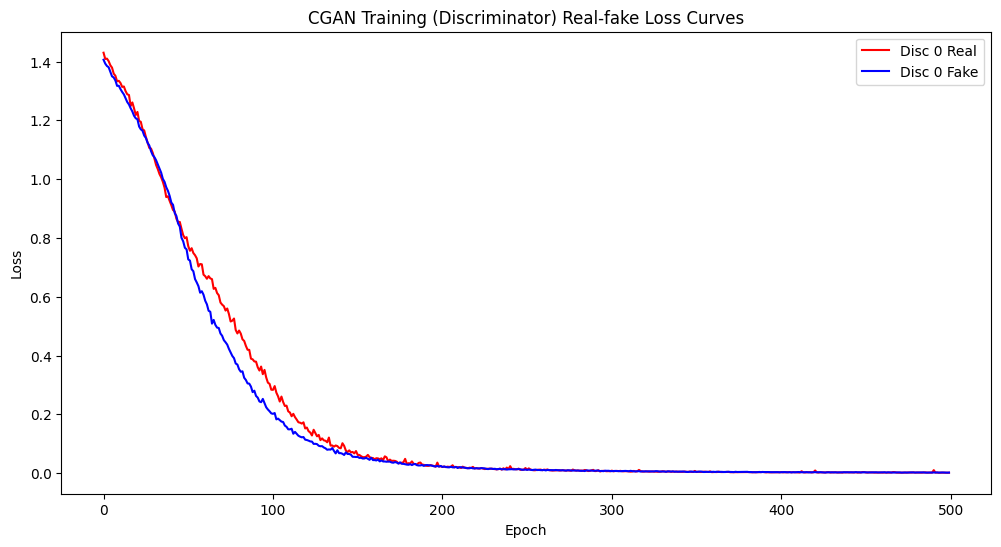

------------ Balance Data Using CGAN ------------
x_test_data shape :  (1200, 29)
count features_test_cols:  29
features_test_cols :  Index(['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8',
       'pca_9', 'pca_10', 'pca_11', 'pca_12', 'pca_13', 'pca_14', 'pca_15',
       'pca_16', 'pca_17', 'pca_18', 'pca_19', 'pca_20', 'pca_21', 'pca_22',
       'pca_23', 'pca_24', 'pca_25', 'pca_26', 'pca_27', 'pca_28', 'pca_29'],
      dtype='object')
------------ balance_data_using_cgan (int) ------------
y_data :     attack_type
0            0
1            0
2            0
3            0
4            1
5            0
6            0
7            0
8            1
9            1
labels_dic:  attack_type
1              607
0              593
Name: count, dtype: int64
max_class_sample:  607 
goal_rows_per_class:  607
num_samples_to_generate :  0
num_samples_to_generate :  14
We generate 14 synthetic samples for attack_type label (0,)
noise:  (14, 29)
generated_labels:  [[1. 0.]


In [24]:

# ---------------------------> Definition <--------------------------- #
BATCH_SIZE = 128      #30   #batch_size = 16
NUM_EPOCHS = 500      # epoch_count = 50
#noise_dim = 100
#n_class = 10

# Save losses for plotting
cd_real_losses = []   # Real Data D losses
cd_fake_losses = []   # Fake data D losses
cd_losses      = []   # discriminator (D) losses
cg_losses      = []   # generator losses



# ---------------------------> Read Data of CSV Files <--------------------------- #
dataset_directory = "/content/datasets"   #files_path
percent = 100
data = read_csv_files(dataset_directory,percent)
print('len data : ' , len(data))

class_Col = 'attack_type'
min_rows_per_class = 2000  #50000
origin_data = data


# >> ---------------------------> Balance Data Before Start <--------------------------- #
#df_balanced_before = balance_data_before_cgan(data, class_Col, min_rows_per_class)
#data = df_balanced_before


# ---------------------------> Apply pre-processing <--------------------------- #
main_text_col = 'sentence'
n_classes, x_train_data, x_test_data, y_train, y_test, origin_x_train, origin_x_test, y_datatype = load_and_preprocess_data1(data)        ## pre-process way 2
num_classes = n_classes
print('-- End pre-process --')


# ---------------------------> Run TDCGAN Models (Gen., Disc., Comb.) - run_TDCGAN_models(old) <--------------------------- #
input_dim = x_train_data.shape[1]     # (features_dim) Dimensionality of TF-IDF vectors
print('features_dim shape: ', input_dim)

## Build the generator
print('G input_dim: ', input_dim)

generator_model = build_generator(input_dim, num_classes)   # random_noise_size / input_shape / input_dim

## Build a discriminator ( disc.)
discriminators_model = []
discriminators_model.append(build_discriminator(input_dim, num_classes, 'discriminator', 3, [100, 100, 100], 0.1))

## Build the combined model (GAN Model)
combined_model = build_combined_model(input_dim, num_classes, generator_model, discriminators_model)



# ---------------------------> print_models_summary <--------------------------- #
print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Print Summary ------------{TextStyle.RESET_ALL}")

## Generator Summary
print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nGenerator summary (CGAN): \n{TextStyle.RESET_ALL}")
generator_model.summary(show_trainable=True,expand_nested=True)   #generator_model.summary()

## Discriminators Summary
print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nDiscriminators summary (CGAN): \n{TextStyle.RESET_ALL}")
discriminators_model[0].summary(show_trainable=True,expand_nested=True)

## Combined Summary
print(f"{TextStyle.BOLD}{TextStyle.BLUE}\nCombined_model summary (CGAN):\n{TextStyle.RESET_ALL} ")
combined_model.summary(show_trainable=True)



# ---------------------------> Train Model <--------------------------- #
print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ train_model ------------{TextStyle.RESET_ALL}")
batch_size = BATCH_SIZE       # 128
noise_dim = input_dim
one_hot_encoder = train_cgan(BATCH_SIZE, noise_dim, num_classes, generator_model, discriminators_model, combined_model, x_train_data, y_train, NUM_EPOCHS)



# >> ---------------------------> Balance Data Using CGAN <--------------------------- #
print(f"{TextStyle.BOLD}{TextStyle.BLACK}------------ Balance Data Using CGAN ------------{TextStyle.RESET_ALL}")

goal_rows_per_class = 1000
features_test_cols = x_test_data.columns
print('x_test_data shape : ', x_test_data.shape)
print('count features_test_cols: ', len(features_test_cols))
print('features_test_cols : ' , features_test_cols)

x_synthetic_data, y_synthetic_data, synthetic_data = balance_data_using_cgan(y_test, input_dim, features_test_cols, class_Col, generator_model, one_hot_encoder, goal_rows_per_class, y_datatype)


# add colum clear instance is real data or fake to help compare in evaluate step
# can't assume all real (1) m because we add new synthetic_data (fake) to them
y_test['is_real'] = np.ones(y_test.shape[0])
print('y_test.shape[0] : ', y_test.shape[0])

y_synthetic_data['is_real'] = np.zeros(y_synthetic_data.shape[0])


# Concatenate synthetic samples with the original dataset
new_x_test_data = pd.concat([x_test_data, x_synthetic_data], ignore_index=True, sort=False)
new_y_test_data = pd.concat([y_test, y_synthetic_data], ignore_index=True, sort=False)
print('new_x_test_data shape : ' , new_x_test_data.shape)
print('new_y_test_data shape : ' , new_y_test_data.shape)
print('new_x_test_data : ' , new_x_test_data)
print('new_y_test_data : ' , new_y_test_data)


print('x_test_data shape : ' , x_test_data.shape)
print('y_test shape : ' , y_test.shape)

print('x_synthetic_data shape : ' , x_synthetic_data.shape)
print('y_synthetic_data shape : ' , y_synthetic_data.shape)




# ---------------------------> Evaluate Model <--------------------------- #
#evaluate_cgan(x_test_data, y_test, n_classes, batch_size, one_hot_encoder)  #, encoder)
evaluate_cgan(new_x_test_data, new_y_test_data, n_classes, batch_size, one_hot_encoder, y_datatype)  #, encoder)

